# Solving one electron problems with sturmian basis.
numpy (general operations), matplotlib (plotting), scipy (generalized eigenvalue problem), numba (faster calculations)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from numba import njit, prange
from tqdm import tqdm
import math

# atoms definitions

EPSILON = 10e-13

ATOMS = {
    "Li": {
        "z": 3,
        "alpha_c": 0.1923,
        "rc": 0.61340824,
        "a1": 2.47718079,
        "a2": 1.84150932,
        "a3": -0.02169712,
        "a4": -0.11988362,
    },
    "Rb":
    {
        "z": 37,
        "alpha_c": 9.0760,
        "rc": 1.66242117,
        "a1": 3.69628474,
        "a2": 1.64915255,
        "a3": -9.86069196,
        "a4": 0.19579987,
    },
    "Cs":
    {
        "z": 55,
        "alpha_c": 15.6440,
        "rc": 1.92046930,
        "a1": 3.49546309,
        "a2": 1.47533800,
        "a3": -9.72143084,
        "a4": 0.02629242,
    },
}

In [4]:
def GLP(x, N, alpha):  # Generalized Laguerre polynomials
    L0 = np.ones_like(x)
    L1 = 1.0 + alpha - x

    if N == 0:
        Ln = L0
    if N == 1:
        Ln = L1

    for n in range(2, N + 1):
        Ln = (((2 * n - 1 + alpha - x)) * L1 - (n - 1 + alpha) * L0) / n
        L0, L1 = L1, Ln
    
    return Ln

# def fix_log_of_zero(value):
#     return np.where(np.abs(value) < EPSILON, EPSILON, value)

# def get_exp(value, e=False, floor=True):
#     value = np.abs(value)
#     value = np.where(value < EPSILON, EPSILON, value)
#     if e:
#         value = np.log(value)
#     else:
#         value = np.log10(value)
#     if floor:
#         return np.floor(value)
#     else:
#         return value

# def LGLP(x, N, alpha):
#     L0 = np.ones_like(x)
#     L0_p = np.zeros_like(x)
#     L1 = 1.0 + alpha - x
#     L1_p = get_exp(L1)
#     L1 /= 10**(L1_p)
    
#     if N == 0:
#         Ln = L0
#         Ln_p = L0_p
#     if N == 1:
#         Ln = L1
#         Ln_p = L1_p
        
#     for n in range(2, N+1):
#         # exponent diff
#         L10_p_diff = L1_p - L0_p
#         Ln = (((2 * n - 1 + alpha - x)) * L1 * (10**(-L10_p_diff)) - (n - 1 + alpha) * L0) / n
#         Ln_p = L0_p + get_exp(Ln)
#         L0_p, L1_p = L1_p, Ln_p
#         L0, L1 = L1, Ln
        
#     return get_exp(Ln, e=True, floor=False) 

def Skl(r, k, l, q):  # Sturmian
    # np.sqrt((factorial(k) / (2 * factorial(2 * l + 1 + k)))) before usage of log gamma function
    return (
        (np.sqrt(2)/2) *
        np.exp(
            (1 / 2) * (math.lgamma(k + 1) - math.lgamma(2 * l + 2 + k))
        )  # Using log gamma to avoid overflow
        * np.exp(-q * r)
        * ((2 * q * r) ** (l + 1))
        * GLP(2 * q * r, k, 2 * l + 1)
    )

def V1(r):
    return -1 / r


def Z(r, z, a1, a2, a3, a4):
    return 1 + (z - 1) * np.exp(-a1 * r) - r * (a3 + a4 * r) * np.exp(-a2 * r)

def V2(r, alpha_c, rc, a1, a2, a3, a4, z):
    return -(Z(r, z, a1, a2, a3, a4)) / r - (alpha_c / (2 * r**4)) * (1 - (np.exp(-((r / rc) ** 6))))

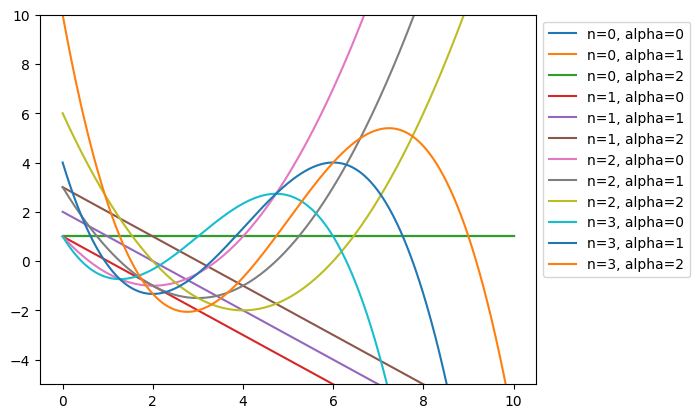

In [5]:
plt.close()

dr = 0.01
r = np.linspace(0.0, 10, 1000)
for i in range(0, 4):
    for j in range(0, 3):
        y = GLP(r, i, j)
        plt.plot(r, y, label=f"n={i}, alpha={j}")
    
plt.ylim(-5, 10)
plt.legend(bbox_to_anchor=(1, 1.0))
plt.show()

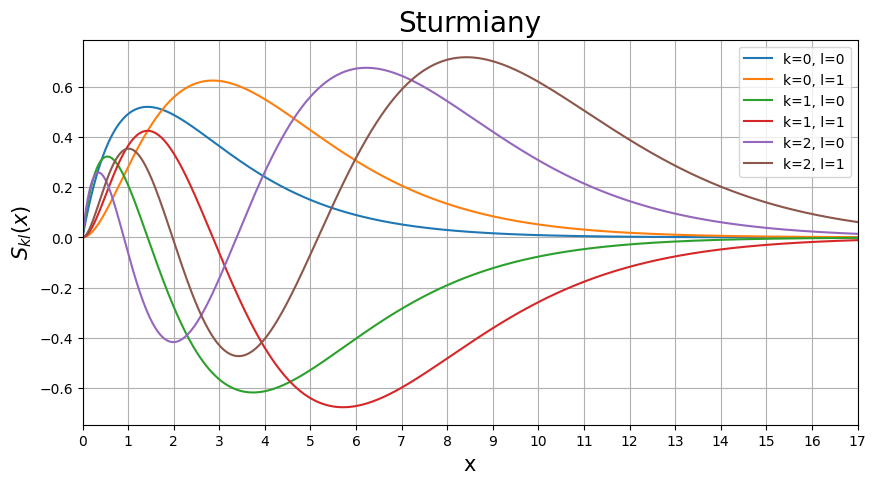

In [26]:
from tkinter import font

plt.close()
plt.figure(figsize=(10, 5))
q = 0.7
max_x = 17
x = np.linspace(0.01, max_x, 1000)

for k in range(0, 3):
    for l in range(0, 2):
        y = Skl(x, k, l, q)
        # ax[0].plot(x, np.abs(y)**2, label=f"k={k}, l={l}")
        plt.plot(x, y, label=f"k={k}, l={l}")

plt.xticks(np.arange(0, 21, 1))
plt.xlim(0.0, max_x)

plt.title("Sturmiany", fontsize=20)
plt.xlabel("x", fontsize=15)
plt.ylabel(r"$S_{kl}(x)$", fontsize=15)
plt.grid()
plt.legend()
plt.show()

In [133]:
r_max = 15
q = 0.7
n = 2
l = 2

Nr = 10000

x = np.linspace(0, r_max, Nr)
y = Skl(x, n, l, q)

print(((y**2) * (r_max / Nr)).sum())

3.3980389541038236


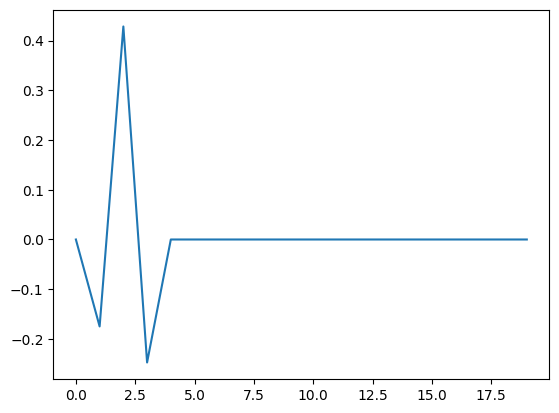

In [134]:
k1, k2 = 2, 1 # k1+1 i k1-1
l1, l2 = 0, 0
q = 0.7
N = 20

dr = 0.01

s = 0
r = np.linspace(0.0, 100, 2000)

s_list = np.zeros(N)

for i, k2 in enumerate(range(N)):
    s_list[i] = (Skl(r, k1, l1, q)*Skl(r, k2, l2, q)*dr).sum()

plt.plot(s_list)

### HB


In [6]:
def HB(N, l, q, r_min, r_max, Nr, dtype):
    print(f"H,B calculation for N={N}, Nr={Nr}")

    x = np.linspace(np.sqrt(r_min), np.sqrt(r_max), Nr + 1, dtype=dtype)
    B = np.zeros((N, N), dtype=dtype)
    H = np.zeros((N, N), dtype=dtype)
    S = np.zeros((N, Nr), dtype=dtype) 
    S_diff = np.zeros((N, Nr), dtype=dtype) # derivative of S

    r1 = x**2
    r = r1[0:-1]
    dr = r1[1:] - r

    V_r = V1(r)
    return HBC(N=N, l=l, q=q, r=r, r1=r1, S=S, S_diff=S_diff, dr=dr, V_r=V_r, H=H, B=B)

# @njit(parallel=True, fastmath=True)
def HBC(N, l, q, r, r1, S, S_diff, dr, V_r, H, B):

    for n in tqdm(range(N)):
        Sn = Skl(r1, n, l, q)
        S[n] = Sn[0:-1]
        S_diff[n] = (Sn[1:]-Sn[:-1])/dr

    for n in tqdm(range(N)):
        for k in range(n, N):
            
            B[n, k] = (S[n] * S[k] * dr).sum()
            
            # Hamiltonian
            H[n, k] = (
                (
                    (1/2)*S_diff[n]*S_diff[k] + 
                    S[n]*S[k]*(V_r + (l)*(l+1)/(2*r**2))
                )
                * (dr)
            ).sum()
            
            # H is symmetric
            if n != k:
                B[k, n] = B[n, k] 
                H[k, n] = H[n, k]
            
    return H, B

NumbaValueError: [1mUnsupported array dtype: float128[0m

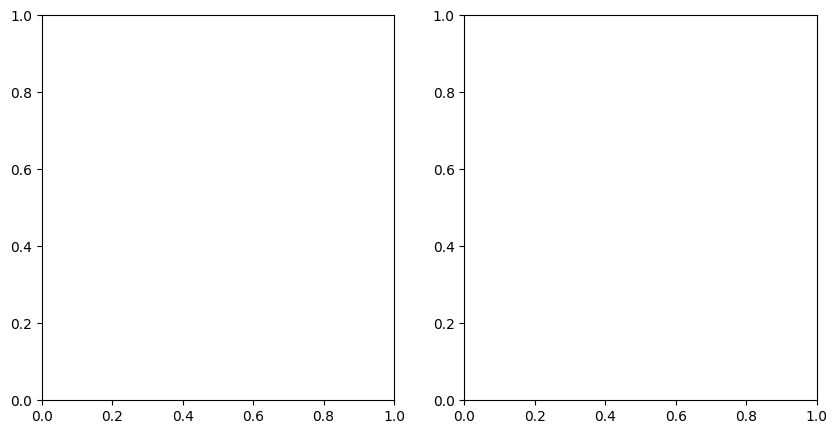

In [8]:
x = np.linspace(0, 3800, 10000, dtype=np.longdouble)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

n = 1250
q = 0.7
l = 0

y1 = Skl(x, n, l, q)
ax[0].plot(x, y1)

In [5]:
N = 100
l = 0
q = 0.7

r_min = 10**-13
r_max = 1000
Nr = 10**4

# V = lambda r: V2(r, **ATOMS["Li"])
V = lambda r: V1(r)

H, B = HB(N, l, q, r_min, r_max, Nr, np.longdouble)

eigenvalues, eigenvectors = sp.linalg.eigh(H, B)

NameError: name 'HB' is not defined

array([-0.50249418, -0.12543583, -0.05570639, -0.03132018, -0.02003855,
       -0.01391244, -0.01021958, -0.00782327, -0.00618065, -0.00500585])

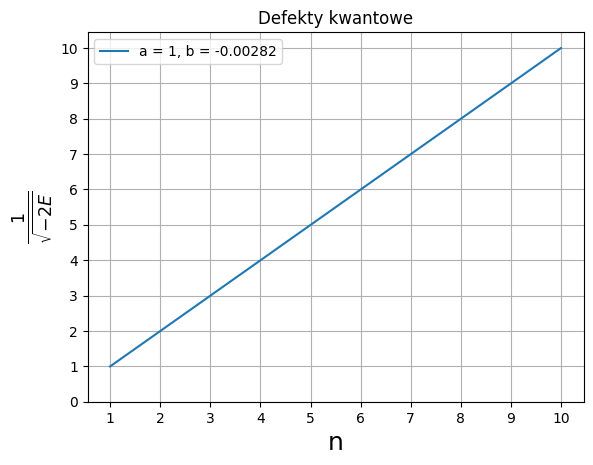

In [189]:
energies = eigenvalues[:10]
n = np.arange(1, len(energies)+1)
Et = 1/np.sqrt(-2*energies)

reg = sp.stats.linregress(n, Et)

plt.plot(n,Et, label=f"a = {reg.slope:.4G}, b = {reg.intercept:.4G}"
plt.grid()
plt.xlabel("n", fontsize=18)
plt.ylabel(r"$\frac{1}{\sqrt{-2E}}$", fontsize=18)
plt.xticks(n)
plt.yticks(np.arange(0, 11, 1))
plt.title("Defekty kwantowe")
plt.legend()
plt.show()

H,B calculation for N=30, Nr=10000


100%|██████████| 30/30 [00:00<00:00, 135.02it/s]


H,B calculation for N=82, Nr=10000


100%|██████████| 82/82 [00:01<00:00, 51.19it/s]


H,B calculation for N=134, Nr=10000


100%|██████████| 134/134 [00:04<00:00, 31.63it/s]


H,B calculation for N=186, Nr=10000


100%|██████████| 186/186 [00:08<00:00, 22.99it/s]


H,B calculation for N=238, Nr=10000


100%|██████████| 238/238 [00:13<00:00, 18.23it/s]


H,B calculation for N=291, Nr=10000


100%|██████████| 291/291 [00:19<00:00, 14.75it/s]


H,B calculation for N=343, Nr=10000


100%|██████████| 343/343 [00:27<00:00, 12.48it/s]


H,B calculation for N=395, Nr=10000


100%|██████████| 395/395 [00:35<00:00, 11.07it/s]


H,B calculation for N=447, Nr=10000


100%|██████████| 447/447 [00:45<00:00,  9.78it/s]


H,B calculation for N=500, Nr=10000


100%|██████████| 500/500 [00:57<00:00,  8.76it/s]


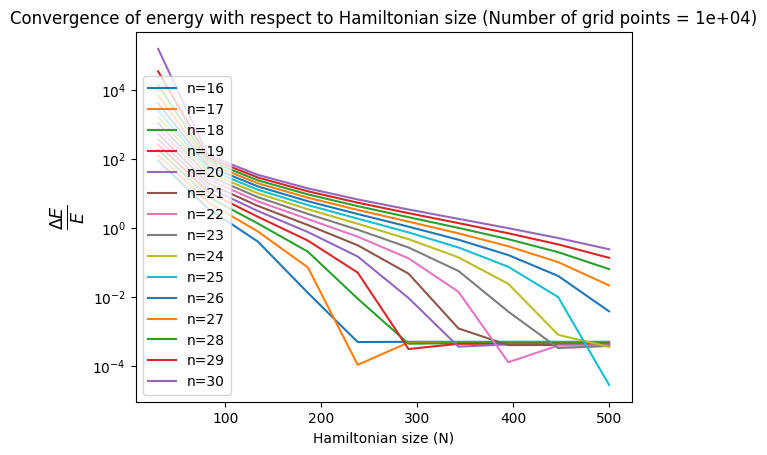

In [142]:
l = 0
q = 0.7

r_min = 10**-13
r_max = 1600
Nr = 10**4

N_list = np.linspace(30, 500, 10).astype(int)
energies = np.zeros((N_list.max(),N_list.shape[0]))
energies.fill(np.nan)

for i, N in enumerate(N_list):
    H, B = HB(N, l, q, r_min, r_max, Nr, np.longdouble)
    try:
        eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
        eigenvalues.sort()
        energies[:eigenvalues.shape[0], i] = eigenvalues
    except Exception as e:
        pass

energies = np.array(energies)

for i in range(15, 30):
    En = (-1/2 *(1/(i + 1)**2))
    plt.plot(N_list, np.abs(energies[i] - En)/np.abs(En), label=f"n={i+1}")
    plt.yscale("log")

# plt.ylim(0.0, 0.6)
plt.title(f"Convergence of energy with respect to Hamiltonian size (Number of grid points = {Nr:.3g})")
plt.xlabel("Hamiltonian size (N)")
plt.ylabel(r"$\frac{\Delta E}{E}$", fontsize=18)
plt.legend()

In [ ]:

n = np.arange()

H,B calculation for N=100, Nr=1


100%|██████████| 100/100 [00:00<00:00, 1336.12it/s]


H,B calculation for N=100, Nr=309


100%|██████████| 100/100 [00:00<00:00, 1149.63it/s]


H,B calculation for N=100, Nr=1168


100%|██████████| 100/100 [00:00<00:00, 824.55it/s]


H,B calculation for N=100, Nr=2578


100%|██████████| 100/100 [00:00<00:00, 641.74it/s]


H,B calculation for N=100, Nr=4538


100%|██████████| 100/100 [00:00<00:00, 478.90it/s]


H,B calculation for N=100, Nr=7048


100%|██████████| 100/100 [00:00<00:00, 375.63it/s]


H,B calculation for N=100, Nr=10109


100%|██████████| 100/100 [00:00<00:00, 283.02it/s]


H,B calculation for N=100, Nr=13721


100%|██████████| 100/100 [00:00<00:00, 226.67it/s]


H,B calculation for N=100, Nr=17883


100%|██████████| 100/100 [00:00<00:00, 178.58it/s]


H,B calculation for N=100, Nr=22596


100%|██████████| 100/100 [00:00<00:00, 147.06it/s]


H,B calculation for N=100, Nr=27859


100%|██████████| 100/100 [00:00<00:00, 117.88it/s]


H,B calculation for N=100, Nr=33672


100%|██████████| 100/100 [00:01<00:00, 82.70it/s]


H,B calculation for N=100, Nr=40036


100%|██████████| 100/100 [00:01<00:00, 65.40it/s]


H,B calculation for N=100, Nr=46951


100%|██████████| 100/100 [00:01<00:00, 53.68it/s]


H,B calculation for N=100, Nr=54416


100%|██████████| 100/100 [00:02<00:00, 46.86it/s]


H,B calculation for N=100, Nr=62432


100%|██████████| 100/100 [00:02<00:00, 37.22it/s]


H,B calculation for N=100, Nr=70998


100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


H,B calculation for N=100, Nr=80115


100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


H,B calculation for N=100, Nr=89782


100%|██████████| 100/100 [00:04<00:00, 23.63it/s]


H,B calculation for N=100, Nr=100000


100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


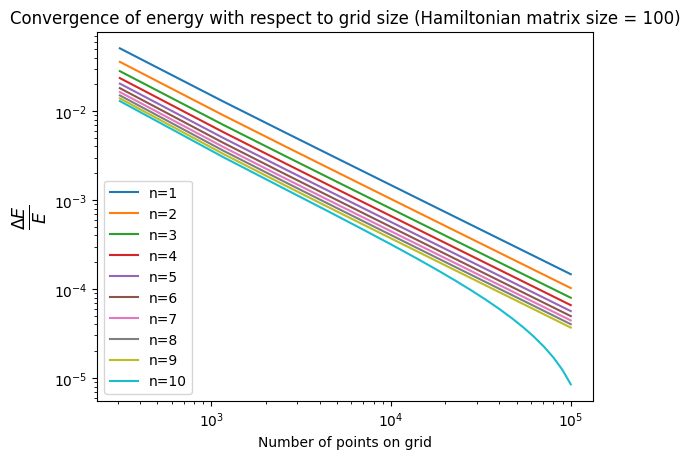

In [85]:
N = 100
l = 0
q = 0.7

r_min = 10**-13
r_max = 350

energies = []
Nr_list = np.linspace(np.sqrt(1.0), np.sqrt(100000), 20)
Nr_list = np.round(Nr_list**2).astype(int)

# Nr_list = [100, 120, 140, 160, 180, 200, 300, 400, 600, 1000, 2000, 5000, 9000, 10000, 11000, 30000, 100000, 500000, 1000000,]
for Nr in Nr_list:
    H, B = HB(N, l, q, r_min, r_max, Nr, np.float64)
    try:
        eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
        eigenvalues.sort()
        energies.append(np.array(eigenvalues))
    except Exception as e:
        energies.append(np.array([np.nan]*N))
energies = np.array(energies)

energies = energies.T

for i in range(10):
    En = (-1/2 *(1/(i + 1)**2))
    plt.plot(Nr_list, np.abs(energies[i] - En)/np.abs(En), label=f"n={i+1}")
    plt.xscale("log")
    plt.yscale("log")

plt.title(f"Convergence of energy with respect to grid size (Hamiltonian matrix size = {N})")
plt.xlabel("Number of points on grid")
plt.ylabel(r"$\frac{\Delta E}{E}$", fontsize=18)
plt.legend()